In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from IPython.display import display
pd.options.display.max_columns = None #show all columns

In [2]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [3]:
train_ID = train_df['Id']
test_ID = test_df['Id']

# Now drop the 'Id' colum since we can not use it as a feature to train our model.
train_df.drop("Id", axis = 1, inplace = True)
test_df.drop("Id", axis = 1, inplace = True)

In [4]:
train_df.shape, test_df.shape

((1460, 80), (1459, 79))

In [5]:
y_train = train_df['SalePrice']
X_train = train_df.drop('SalePrice', axis=1)
X_test = test_df.copy()

In [6]:
X_train.shape,X_test.shape

((1460, 79), (1459, 79))

In [7]:
all_data = pd.concat([X_train, X_test], ignore_index=True)
all_data.shape

(2919, 79)

## Imputing missing values 

In [8]:
all_data.LotFrontage = all_data.LotFrontage.fillna(all_data.LotFrontage.dropna().median())
all_data.GarageYrBlt = all_data.GarageYrBlt.fillna(all_data.GarageYrBlt.dropna().median())

for c in all_data.columns:
    if all_data[c].dtype == 'object':
        all_data[c] = all_data[c].fillna('Unavailable')
    else:
        all_data[c] = all_data[c].fillna(0)

## Changing certain numerical columns to categorical

In [9]:
all_data.MSSubClass = all_data.MSSubClass.astype('category')
all_data.OverallQual = all_data.OverallQual.astype('category')
all_data.OverallCond = all_data.OverallCond.astype('category')
all_data.GarageCars = all_data.GarageCars.astype('category')
all_data.YrSold = all_data.YrSold.astype('category')

In [10]:
all_data['Fireplaces'] = np.where(all_data['Fireplaces'] == 0, 'No', 'Yes')
all_data['PoolArea'] = np.where(all_data['PoolArea'] == 0, 'No', 'Yes')

## Adding variables together 

In [11]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data.drop(['TotalBsmtSF','1stFlrSF','2ndFlrSF'], axis = 1, inplace = True)
all_data.shape

(2919, 77)

In [12]:
all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] + all_data['FullBath'] + all_data['HalfBath']
all_data.drop(['HalfBath','FullBath','BsmtHalfBath','BsmtFullBath'], inplace=True, axis=1)
all_data.shape

(2919, 74)

In [13]:
all_data['TotalPorchSF'] = all_data['WoodDeckSF'] + all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
all_data.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'], inplace=True, axis=1)
all_data.shape

(2919, 70)

In [14]:
X_train = all_data[:y_train.shape[0]]
X_test = all_data[y_train.shape[0]:]
print(X_train.shape, X_test.shape, y_train.shape)

(1460, 70) (1459, 70) (1460,)


## Transformation of target

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a237e8828>,
      dtype=object)

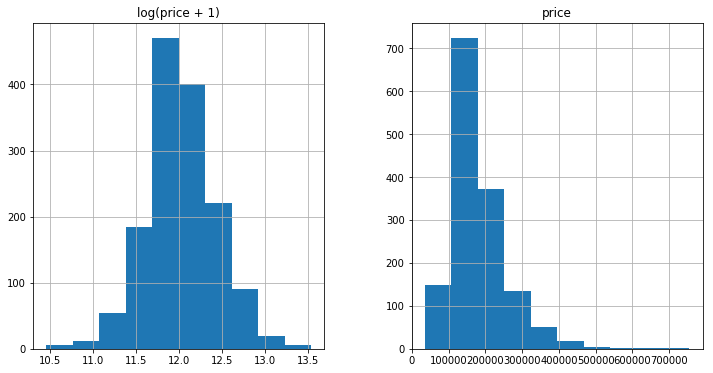

In [29]:
plt.rcParams['figure.figsize'] = (12.0,6.0)
logy_train  = np.log1p(y_train) #log(1 + y_train)
prices = pd.DataFrame({"price":y_train, "log(price + 1)":logy_train})
prices.hist()

-0.07692396374428875


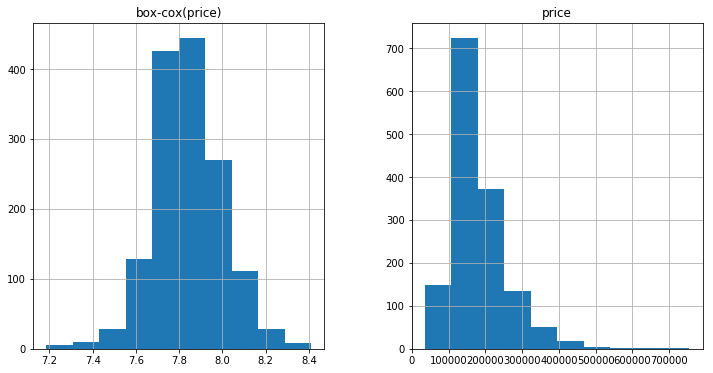

In [30]:
from scipy.stats import boxcox
ybox_train, lambda_ = boxcox(y_train )
prices = pd.DataFrame({"price":y_train, "box-cox(price)":ybox_train})
prices.hist()
print(lambda_)

## Transformation of numerical features

In [16]:
#Find numeric features in train and test data (except "SalePrice")
numeric_feats = all_data._get_numeric_data().columns
print(numeric_feats)
X_train_numeric  = X_train[numeric_feats]
X_train_skew = pd.DataFrame({'skewed' :X_train_numeric.skew()>0.75}) 
high_skew_feats = X_train_skew[X_train_skew.skewed].index
print(high_skew_feats)
all_data[high_skew_feats] = np.log1p(all_data[high_skew_feats]) #log(1+x)

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'MiscVal', 'MoSold', 'TotalSF', 'TotalBath',
       'TotalPorchSF'],
      dtype='object')
Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'LowQualFinSF', 'GrLivArea', 'KitchenAbvGr', 'MiscVal',
       'TotalSF', 'TotalPorchSF'],
      dtype='object')


In [17]:
all_data.shape, X_train.shape, X_test.shape, y_train.shape, y_box.shape

((2919, 70), (1460, 70), (1459, 70), (1460,), (1460,))

## Encoding of categorical variables

In [18]:
#one_hot_df = pd.get_dummies(all_data, drop_first=True)
one_hot_df = pd.get_dummies(all_data, drop_first=True, dummy_na=True)
one_hot_df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,MiscVal,MoSold,TotalSF,TotalBath,TotalPorchSF,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_Unavailable,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_Unavailable,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_NoSeWa,Utilities_Unavailable,Utilities_nan,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,OverallQual_2.0,OverallQual_3.0,OverallQual_4.0,OverallQual_5.0,OverallQual_6.0,OverallQual_7.0,OverallQual_8.0,OverallQual_9.0,OverallQual_10.0,OverallQual_nan,OverallCond_2.0,OverallCond_3.0,OverallCond_4.0,OverallCond_5.0,OverallCond_6.0,OverallCond_7.0,OverallCond_8.0,OverallCond_9.0,OverallCond_nan,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Unavailable,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Unavailable,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unavailable,MasVnrType_nan,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unavailable,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unavailable,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unavailable,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unavailable,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unavailable,BsmtFinType2_Unf,BsmtFinType2_nan,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,Heatin

In [19]:
one_hot_df.shape  #(295 features with dummy_na = False, 345 features with dummy_na = True)

(2919, 345)

In [40]:
X_train = one_hot_df[:y_train.shape[0]]
X_test = one_hot_df[y_train.shape[0]:]
print(X_train.shape, X_test.shape, y_train.shape)

(1460, 345) (1459, 345) (1460,)


## Lasso regression

In [33]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((1095, 345), (1095,), (365, 345), (365,))

In [111]:
#lasso = linear_model.Lasso(alpha=1) #default tol = 0.001, max_iter =1000:  0.94151, 0.67897, 0.86862 throws ConvergenceWarning
#lasso = linear_model.Lasso(alpha=1, tol=0.001) #0.94151, 0.67897, 0.86862 throws ConvergenceWarning
#lasso = linear_model.Lasso(alpha=1, tol=0.01) #0.94151, 0.67897, 0.86862 throws ConvergenceWarning
#lasso = linear_model.Lasso(alpha=1, tol=0.01, max_iter=10000) #0.94153, 0.67909, 0.86867 no warning, but takes longer 
lasso = linear_model.Lasso(alpha=1, tol=0.1) #0.90502, 0.81212, 0.87925 selected
#lasso = linear_model.Lasso(alpha=1, tol=1.0) #0.86872, 0.78982, 0.84685
#lasso = linear_model.Lasso(alpha=1, tol=1e-4, max_iter=10000, selection='random') #0.93533, 0.76734, 0.88870

lasso.fit(x_tr, y_tr)
train_score =  lasso.score(x_tr, y_tr)
val_score = lasso.score(x_val, y_val)
total_score = lasso.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)
cv_score = cross_val_score(lasso, X_train, y_train,  cv=5).mean() #R^2  0.80542
cv_score_ = cross_val_score(lasso, X_train, y_train, scoring  = 'explained_variance', cv=5).mean()
cv_score2 = cross_val_score(lasso, X_train, y_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
print('Explained_variance from cross-validation ', cv_score_.round(5))
print('RMSE from cross-validation ', np.sqrt(-cv_score2).round())

The training   R^2 is: 0.90614
The validation R^2 is: 0.81022
R^2 for total train data is: 0.87954
R^2 from cross-validation  0.80542
Explained_variance from cross-validation  0.8061
RMSE from cross-validation  35347.0


In [58]:
lasso_coef =  pd.Series(lasso.coef_, index = X_train.columns)
lasso_coef.sort_values(ascending =False).head(10)

OverallQual_10.0        100388.858313
GrLivArea                91249.287511
RoofMatl_Metal           77350.629823
SaleCondition_Alloca     72459.136457
RoofMatl_WdShngl         71105.660733
RoofMatl_Tar&Grv         61873.517036
RoofMatl_Roll            47014.122296
Neighborhood_StoneBr     44125.915509
RoofMatl_WdShake         43855.845014
Exterior2nd_ImStucc      43133.061746
dtype: float64

Text(0,0.5,'y_predict')

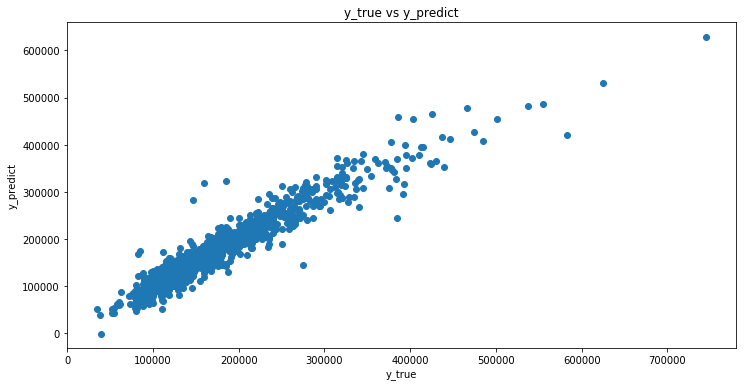

In [59]:
plt.scatter(y_tr, lasso.predict(x_tr))
plt.title('y_true vs y_predict')
plt.xlabel('y_true')
plt.ylabel('y_predict')

In [35]:
x_tr, x_val, ybox_tr, ybox_val = train_test_split(X_train, ybox_train, test_size=0.25, random_state=42)
x_tr.shape, ybox_tr.shape, x_val.shape, ybox_val.shape

((1095, 345), (1095,), (365, 345), (365,))

In [115]:
lasso2 = linear_model.Lasso(alpha=0.001,  tol=0.1) #Note: alpha = 1 already gives bad R^2
lasso2.fit(x_tr, ybox_tr)
train_score =  lasso2.score(x_tr, ybox_tr)
val_score = lasso2.score(x_val, ybox_val)
total_score = lasso2.score(X_train, ybox_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)
cv_score = cross_val_score(lasso2, X_train, ybox_train,  cv=5).mean() #R^2  
cv_score_ = cross_val_score(lasso2, X_train, ybox_train, scoring  = 'explained_variance', cv=5).mean()
cv_score2 = cross_val_score(lasso2, X_train, ybox_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
print('Explained_variance from cross-validation ', cv_score_.round(5))
print('RMSE from cross-validation ', np.sqrt(-cv_score2).round(5))

The training   R^2 is: 0.86793
The validation R^2 is: 0.85363
R^2 for total train data is: 0.86417
R^2 from cross-validation  0.85035
Explained_variance from cross-validation  0.85111
RMSE from cross-validation  0.06106


In [67]:
lasso2_coef =  pd.Series(lasso2.coef_, index = X_train.columns)
lasso2_coef.sort_values(ascending =False).head()

GrLivArea               0.188423
LotArea                 0.052703
Functional_Typ          0.034226
OverallQual_9.0         0.032136
Neighborhood_Crawfor    0.030258
dtype: float64

Text(0,0.5,'y_predict')

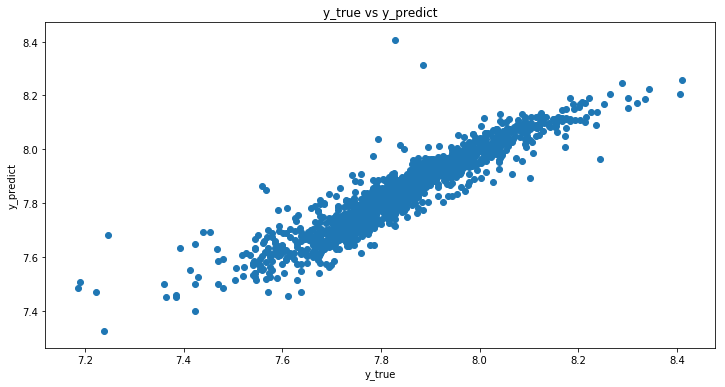

In [116]:
plt.scatter(ybox_train, lasso2.predict(X_train))
plt.title('y_true vs y_predict')
plt.xlabel('y_true')
plt.ylabel('y_predict')

In [38]:
x_tr, x_val, logy_tr, logy_val = train_test_split(X_train, logy_train, test_size=0.25, random_state=42)
x_tr.shape, logy_tr.shape, x_val.shape, logy_val.shape

((1095, 345), (1095,), (365, 345), (365,))

In [118]:
lasso3 = linear_model.Lasso(alpha=0.001, tol=0.01) #R^2 0.76476, RMSE 38138.0
#lasso3 = linear_model.Lasso(alpha=0.001, tol=0.01, max_iter=10000) #R^2 0.76459, RMSE 38152.0
lasso3.fit(x_tr, logy_tr) 
train_score =  lasso3.score(x_tr, logy_tr)
val_score = lasso3.score(x_val, logy_val)
total_score = lasso3.score(X_train, logy_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)
cv_score = cross_val_score(lasso3, X_train, logy_train,  cv=5).mean() #R^2  
cv_score_ = cross_val_score(lasso3, X_train, logy_train, scoring  = 'explained_variance', cv=5).mean()
cv_score2 = cross_val_score(lasso3, X_train, logy_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
print('Explained_variance from cross-validation ', cv_score_.round(5))
print('RMSE from cross-validation ', np.sqrt(-cv_score2))

The training   R^2 is: 0.91045
The validation R^2 is: 0.89366
R^2 for total train data is: 0.90597
R^2 from cross-validation  0.89347
Explained_variance from cross-validation  0.89401
RMSE from cross-validation  0.13025037618791555


In [70]:
lasso3_coef =  pd.Series(lasso3.coef_, index = X_train.columns)
lasso3_coef.sort_values(ascending =False).head()

GrLivArea               0.261574
TotalSF                 0.198308
OverallQual_9.0         0.160349
Exterior1st_BrkFace     0.108131
Neighborhood_Crawfor    0.098639
dtype: float64

Text(0,0.5,'y_predict')

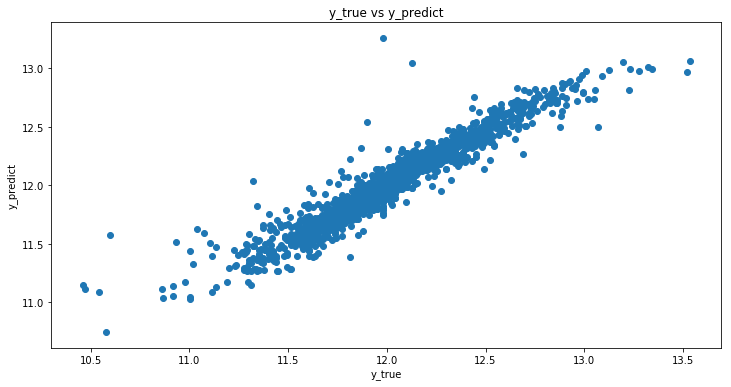

In [119]:
plt.scatter(logy_train, lasso3.predict(X_train))
plt.title('y_true vs y_predict')
plt.xlabel('y_true')
plt.ylabel('y_predict')

### 5-fold cross-validation

In [120]:
def rmsle(y, y_pred): #root mean square log error
    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))
def rmse_cv(model, X, y): #cross-validation root mean square error
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = 5))
    return(rmse)


alpha_vals = np.logspace(-4, 4, 100) #penalty parameter of Lasso regression, scanning over base 10 log scale. Need to scan finer. maybe do 1000
model_lasso_5CV = LassoCV(alphas = alpha_vals, normalize=True, 
                          cv=5, tol=0.01, n_jobs=-1, max_iter=10000).fit(X_train, y_train) 
print("Best alpha value: " + str(model_lasso_5CV.alpha_))
print("coefficient of determination R^2 : " + str(model_lasso_5CV.score(X_train, y_train)))
x = rmse_cv(model_lasso_5CV, X_train, y_train)
print("With 5-fold CV, the RMSE values are: " + str(x))
print("Average RootMeanSquareError (RMSE): " + str(x.mean()))

Best alpha value: 25.950242113997373
coefficient of determination R^2 : 0.8918525156682405
With 5-fold CV, the RMSE values are: [36920.31977118 30961.8637143  35132.87593986 24501.55950264
 37225.04963038]
Average RootMeanSquareError (RMSE): 32948.333711673054


In [142]:
model_lasso_5CV.coef_.shape, alpha_vals.shape , X_train.shape

((345,), (100,), (1460, 345))

In [135]:
model_lasso_5CV.coef_ #each variable/feature gets a coefficient, some of them zero

array([ 0.00000000e+00,  1.44508515e+04,  2.37007742e+02,  1.84437501e+02,
        0.00000000e+00,  1.30020084e+03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  3.82039579e+04, -2.02304833e+02, -4.03682837e+04,
        1.25072526e+03,  0.00000000e+00,  1.02088109e+01, -0.00000000e+00,
       -0.00000000e+00,  3.92013997e+04,  5.50650855e+03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -1.04226344e+03, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -1.03590522e+03,  0.00000000e+00,
        1.56743832e+03,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.25778355e+04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  3.29331861e+03,
       -7.37783808e+03, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

In [136]:
alpha_vals

array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97702356e-03, 5.99484250e-03, 7.22080902e-03,
       8.69749003e-03, 1.04761575e-02, 1.26185688e-02, 1.51991108e-02,
       1.83073828e-02, 2.20513074e-02, 2.65608778e-02, 3.19926714e-02,
       3.85352859e-02, 4.64158883e-02, 5.59081018e-02, 6.73415066e-02,
       8.11130831e-02, 9.77009957e-02, 1.17681195e-01, 1.41747416e-01,
       1.70735265e-01, 2.05651231e-01, 2.47707636e-01, 2.98364724e-01,
       3.59381366e-01, 4.32876128e-01, 5.21400829e-01, 6.28029144e-01,
       7.56463328e-01, 9.11162756e-01, 1.09749877e+00, 1.32194115e+00,
       1.59228279e+00, 1.91791026e+00, 2.31012970e+00, 2.78255940e+00,
      

### Lasso coefficients as a function of the regularization

In [138]:
lasso = linear_model.Lasso(alpha=1, tol=0.01)
#lasso = linear_model.Lasso(alpha=1)
alphas_lasso = np.logspace(-4, 4, 100)
coef_lasso = [] #going to get one coef_ value for each alpha
for i in alphas_lasso:
    lasso.set_params(alpha=i).fit(X_train,y_train)
    coef_lasso.append(lasso.coef_)
    

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: 

In [141]:
type(coef_lasso), len(coef_lasso)

(list, 100)

In [146]:
len(coef_lasso[0]), X_train.shape

(345, (1460, 345))

In [147]:
plt.figure(figsize=(20,20))
columns = X_train.columns
df_coef = pd.DataFrame(coef_lasso, index=alphas_lasso, columns=columns)
df_coef.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,MiscVal,MoSold,TotalSF,TotalBath,TotalPorchSF,MSSubClass_30.0,MSSubClass_40.0,MSSubClass_45.0,MSSubClass_50.0,MSSubClass_60.0,MSSubClass_70.0,MSSubClass_75.0,MSSubClass_80.0,MSSubClass_85.0,MSSubClass_90.0,MSSubClass_120.0,MSSubClass_150.0,MSSubClass_160.0,MSSubClass_180.0,MSSubClass_190.0,MSSubClass_nan,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_Unavailable,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_Unavailable,Alley_nan,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotShape_nan,LandContour_HLS,LandContour_Low,LandContour_Lvl,LandContour_nan,Utilities_NoSeWa,Utilities_Unavailable,Utilities_nan,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LotConfig_nan,LandSlope_Mod,LandSlope_Sev,LandSlope_nan,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Neighborhood_nan,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition1_nan,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,Condition2_nan,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BldgType_nan,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,HouseStyle_nan,OverallQual_2.0,OverallQual_3.0,OverallQual_4.0,OverallQual_5.0,OverallQual_6.0,OverallQual_7.0,OverallQual_8.0,OverallQual_9.0,OverallQual_10.0,OverallQual_nan,OverallCond_2.0,OverallCond_3.0,OverallCond_4.0,OverallCond_5.0,OverallCond_6.0,OverallCond_7.0,OverallCond_8.0,OverallCond_9.0,OverallCond_nan,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofStyle_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,RoofMatl_nan,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Unavailable,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior1st_nan,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_Unavailable,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Exterior2nd_nan,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,MasVnrType_Unavailable,MasVnrType_nan,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterQual_nan,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,ExterCond_nan,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Foundation_nan,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,BsmtQual_Unavailable,BsmtQual_nan,BsmtCond_Gd,BsmtCond_Po,BsmtCond_TA,BsmtCond_Unavailable,BsmtCond_nan,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Unavailable,BsmtExposure_nan,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Rec,BsmtFinType1_Unavailable,BsmtFinType1_Unf,BsmtFinType1_nan,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_Rec,BsmtFinType2_Unavailable,BsmtFinType2_Unf,BsmtFinType2_nan,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Heating_nan,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,Heatin

<Figure size 1440x1440 with 0 Axes>

Text(0,0.5,'coefficients')

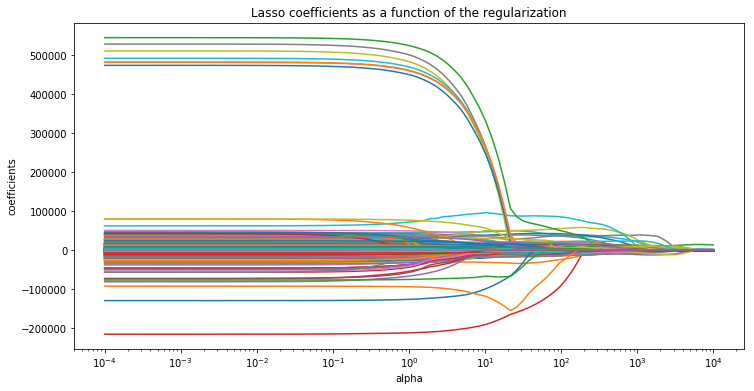

In [148]:
title = 'Lasso coefficients as a function of the regularization'
df_coef.plot(logx=True, title=title, legend=False)
plt.xlabel('alpha')
plt.ylabel('coefficients')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
#plt.axvline(x=model_lasso_5CV.alpha_,ls="dashed")
#plt.savefig('./lasso.png', bbox_inches='tight', dpi = 300)

In [149]:
#coeffs for best model 
beta_vals = pd.Series(model_lasso_5CV.coef_, index = X_train.columns)
beta_vals.head()

LotFrontage         0.000000
LotArea         14450.851459
YearBuilt         237.007742
YearRemodAdd      184.437501
MasVnrArea          0.000000
dtype: float64

In [150]:
print("Variables kept: " + str(sum(beta_vals != 0)))
print("Variables eliminated: " + str(sum(beta_vals == 0)))

Variables kept: 81
Variables eliminated: 264


### Important features

In [151]:
important_feat = pd.concat([beta_vals.sort_values().head(15), beta_vals.sort_values().tail(15)])

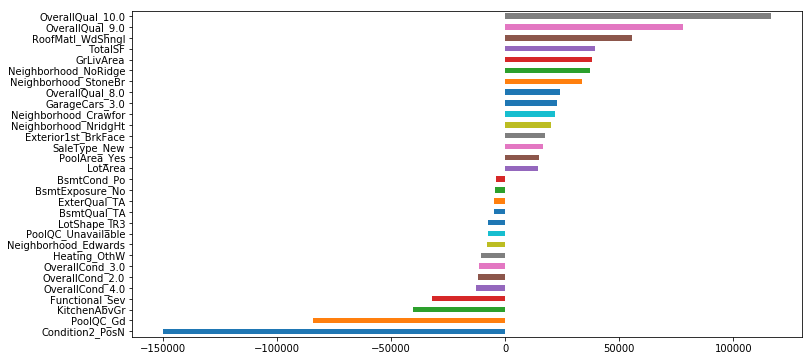

In [152]:
important_feat.plot(kind = "barh")
#plt.title("Coefficients in the Lasso Model")
plt.show()

### Plotting the actual vs expected house price 

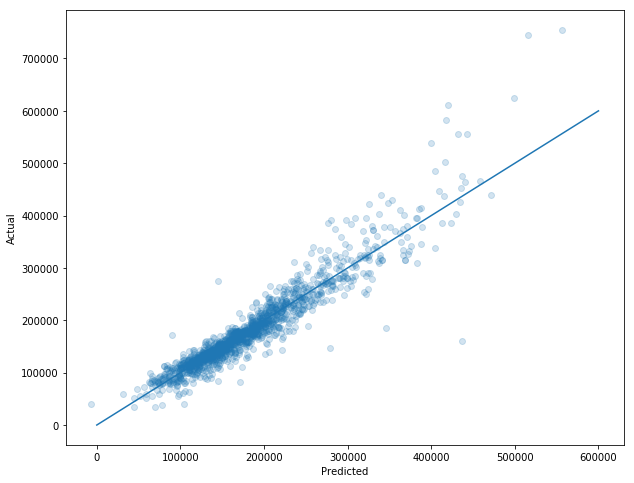

In [153]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
plt.figure(figsize=(10,8))
plt.scatter(model_lasso_5CV.predict(X_train), y_train, alpha=.2)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");

### Residual against predicted house price

Text(0,0.5,'Residual')

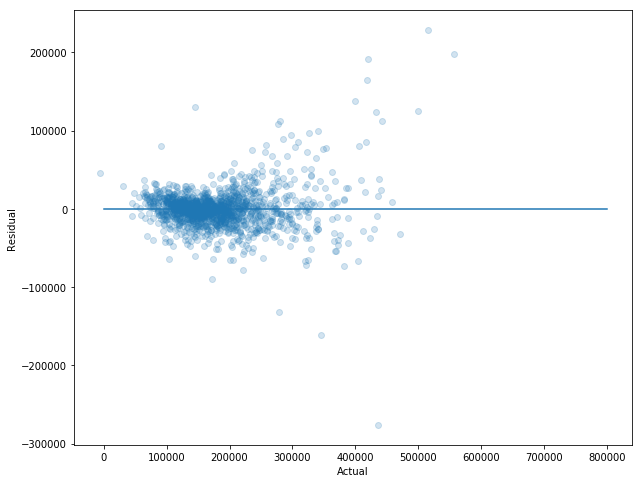

In [34]:
plt.figure(figsize=(10,8))
plt.scatter(model_lasso_5CV.predict(X_train), y_train - model_lasso_5CV.predict(X_train), alpha=.2)
plt.plot(np.linspace(0,800000,1000), np.linspace(0,0,1000))
plt.xlabel("Actual")
plt.ylabel("Residual")

### Creating submission output file

In [155]:
ID = test_ID
result_lasso = model_lasso_5CV.predict(X_test)

In [36]:
result_lasso[:10]

array([108963.0544599 , 159840.2316158 , 190519.95910976, 192222.69190017,
       215027.3516535 , 172606.34833785, 168372.49340062, 164152.31057551,
       202978.83299137, 116051.33582068])

In [156]:
#score from Kaggle's public leaderboard 0.14739
output = pd.DataFrame( { 'id': ID , 'SalePrice': result_lasso} )
output = output[['id', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,108963.054460
1,1462,159840.231616
2,1463,190519.959110
3,1464,192222.691900
4,1465,215027.351653
5,1466,172606.348338
6,1467,168372.493401
7,1468,164152.310576
8,1469,202978.832991
9,1470,116051.335821


## log transformed y

In [191]:
#def rmsle(y, y_pred): #root mean square log error
#    return np.sqrt(mean_squared_error(np.log(y), np.log(y_pred)))
#def rmse_cv(model, X, y): #cross-validation root mean square error
#    rmse = np.sqrt(-cross_val_score(model, X, y, scoring = 'neg_mean_squared_error', cv = 5))
#    return(rmse)

alpha_vals = np.logspace(-8, 0, 100) #penalty parameter of Lasso regression, scanning over base 10 log scale. Need to scan finer. maybe do 1000
model_lasso_log_5CV = LassoCV(alphas = alpha_vals, normalize=True, 
                          cv=5, tol=0.01, n_jobs=-1, max_iter=10000).fit(X_train, logy_train) 
print("Best alpha value: " + str(model_lasso_log_5CV.alpha_))
print("coefficient of determination R^2 : " + str(model_lasso_log_5CV.score(X_train, logy_train)))
cv_score = cross_val_score(model_lasso_log_5CV, X_train, logy_train,  cv=5).mean()
print("5-fold cross-validation ", cv_score )


Best alpha value: 0.00010974987654930568
coefficient of determination R^2 : 0.920050586296685
5-fold cross-validation  0.8904636064273446


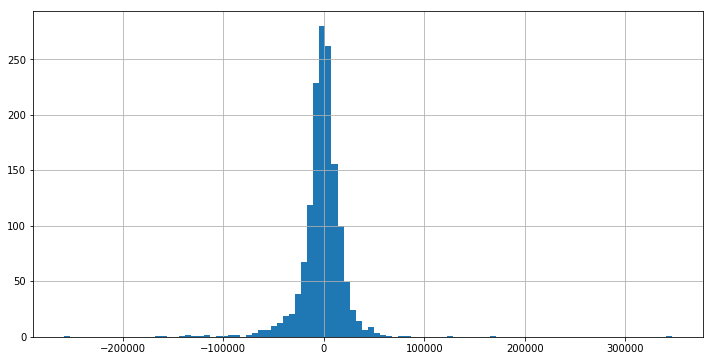

In [195]:
residue_log = np.expm1(model_lasso_log_5CV.predict(X_train))- y_train
residue_log.hist(bins =100)

In [199]:
rmse_score = np.sqrt((residue_log **2).mean())
rmse_score

24385.092041928583

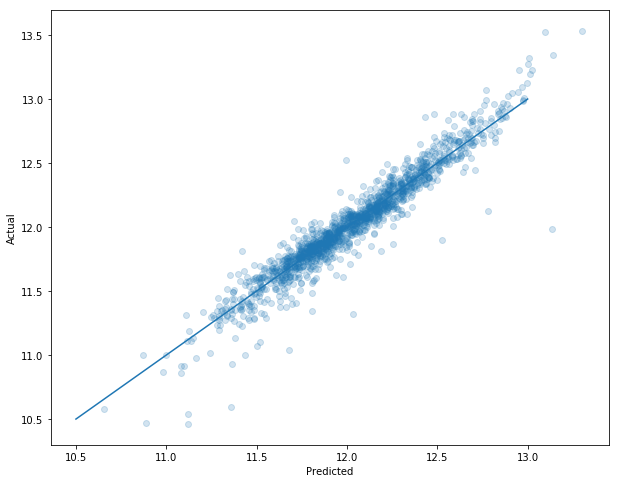

In [169]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
plt.figure(figsize=(10,8))
plt.scatter(model_lasso_log_5CV.predict(X_train), logy_train, alpha=.2)
plt.plot(np.linspace(10.5,13.0,1000), np.linspace(10.5,13.0,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [179]:
#Kaggle score 0.13296
ID = test_ID
result_lasso_log = np.expm1(model_lasso_log_5CV.predict(X_test))
output = pd.DataFrame( { 'id': ID , 'SalePrice': result_lasso_log} )
output = output[['id', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,116792.753289
1,1462,155002.409801
2,1463,191938.690150
3,1464,193557.116746
4,1465,198362.861687
5,1466,175651.114951
6,1467,174026.644482
7,1468,166516.339082
8,1469,201510.046322
9,1470,118999.616678


In [178]:
output.head()

,id,SalePrice
0,1461,116792.753289
1,1462,155002.409801
2,1463,191938.690150
3,1464,193557.116746
4,1465,198362.861687


## Box-Cox transformed y

In [190]:
alpha_vals = np.logspace(-8, 0, 100) #penalty parameter of Lasso regression, scanning over base 10 log scale. Need to scan finer. maybe do 1000
model_lasso_box_5CV = LassoCV(alphas = alpha_vals, normalize=True, 
                          cv=5, tol=0.01, n_jobs=-1, max_iter=10000).fit(X_train, ybox_train) 
print("Best alpha value: " + str(model_lasso_box_5CV.alpha_))
print("coefficient of determination R^2 : " + str(model_lasso_box_5CV.score(X_train, ybox_train)))
cv_score = cross_val_score(model_lasso_box_5CV, X_train, ybox_train,  cv=5).mean()
print("5-fold cross-validation ", cv_score )


Best alpha value: 4.328761281083062e-05
coefficient of determination R^2 : 0.9188552145192753
5-fold cross-validation  0.888173613671589


24448.890262794994

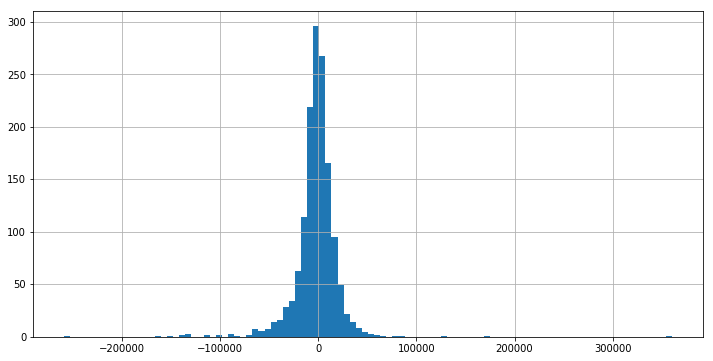

In [200]:
from scipy.special import inv_boxcox
residue_box = inv_boxcox(model_lasso_box_5CV.predict(X_train), lambda_)- y_train #lambda_ = -0.07692396374428875
residue_box.hist(bins =100)
rmse_score = np.sqrt((residue_box **2).mean())
rmse_score

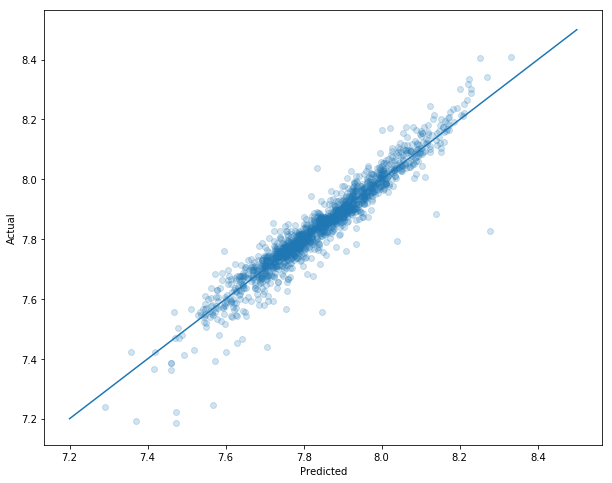

In [175]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
plt.figure(figsize=(10,8))
plt.scatter(model_lasso_box_5CV.predict(X_train), ybox_train, alpha=.2)
plt.plot(np.linspace(7.2,8.5,1000), np.linspace(7.2,8.5,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [181]:
#Kaggle score  0.13217

ID = test_ID
result_lasso_box = inv_boxcox(model_lasso_box_5CV.predict(X_test), lambda_)  #lambda_ = -0.07692396374428875
output = pd.DataFrame( { 'id': ID , 'SalePrice': result_lasso_box} )
output = output[['id', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,116998.861712
1,1462,154709.156381
2,1463,192109.545610
3,1464,193991.579202
4,1465,197127.046318
5,1466,175940.875642
6,1467,174523.224483
7,1468,166823.379278
8,1469,201288.555666
9,1470,119102.048685


### Tree-based models

In [182]:
from sklearn.model_selection import train_test_split

In [183]:
x_tr, x_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
x_tr.shape, y_tr.shape, x_val.shape, y_val.shape

((1095, 345), (1095,), (365, 345), (365,))

In [186]:

from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor(random_state = 42)
randomForest.fit(x_tr, y_tr)
train_score =  randomForest.score(x_tr, y_tr)
val_score = randomForest.score(x_val, y_val)
total_score = randomForest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

cv_score = cross_val_score(randomForest, X_train, y_train,  cv=5).mean() #R^2  
cv_score_ = cross_val_score(randomForest, X_train, y_train, scoring  = 'explained_variance', cv=5).mean()
cv_score2 = cross_val_score(randomForest, X_train, y_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
print('Explained_variance from cross-validation ', cv_score_.round(5))
print('RMSE from cross-validation ', np.sqrt(-cv_score2).round(5))



The training   R^2 is: 0.96701
The validation R^2 is: 0.85281
R^2 for total train data is: 0.93530
R^2 from cross-validation  0.8299
Explained_variance from cross-validation  0.83013
RMSE from cross-validation  32899.93049


In [201]:
feature_importance = list(zip(x_tr.columns, randomForest.feature_importances_))
feature_df = pd.DataFrame(feature_importance,columns = ['feature','importance']).sort_values('importance', ascending =False)
feature_df.head()

,feature,importance
17,TotalSF,0.666550
2,YearBuilt,0.045072
289,GarageCars_3.0,0.036345
5,BsmtFinSF1,0.018776
3,YearRemodAdd,0.018163


<BarContainer object of 20 artists>

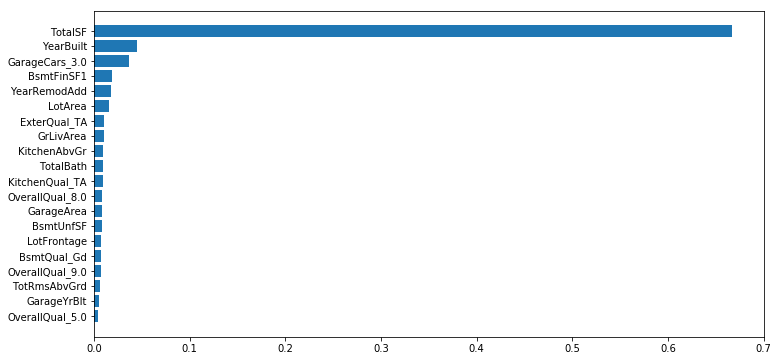

In [202]:
plt.barh(feature_df.feature[:20][::-1], feature_df.importance[:20][::-1])

In [203]:
randomForest = ensemble.RandomForestRegressor(n_estimators =100,  random_state = 42) #oob did not make any difference
randomForest.fit(x_tr, y_tr)
train_score =  randomForest.score(x_tr, y_tr)
val_score = randomForest.score(x_val, y_val)
total_score = randomForest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

cv_score = cross_val_score(randomForest, X_train, y_train,  cv=5).mean() #R^2  
cv_score_ = cross_val_score(randomForest, X_train, y_train, scoring  = 'explained_variance', cv=5).mean()
cv_score2 = cross_val_score(randomForest, X_train, y_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
print('Explained_variance from cross-validation ', cv_score_.round(5))
print('RMSE from cross-validation ', np.sqrt(-cv_score2).round(5))

The training   R^2 is: 0.97613
The validation R^2 is: 0.87576
R^2 for total train data is: 0.94826
R^2 from cross-validation  0.83657
Explained_variance from cross-validation  0.83687
RMSE from cross-validation  32240.73718


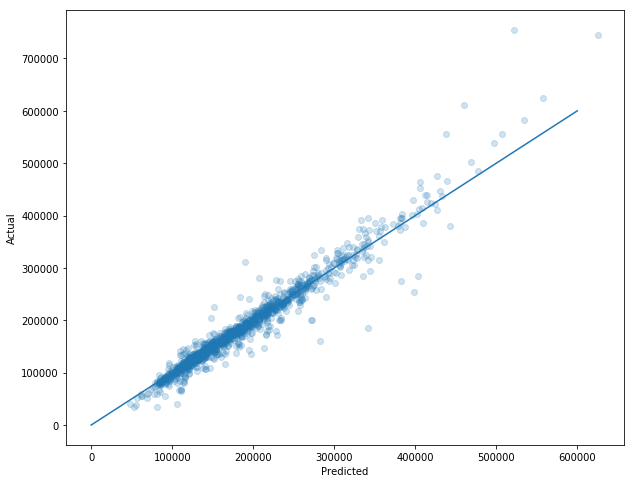

In [215]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
plt.figure(figsize=(10,8))
plt.scatter(randomForest.predict(X_train), y_train, alpha=.2)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");

In [216]:
randomForest = ensemble.RandomForestRegressor(n_estimators =100,  random_state = 42)
cv_score = cross_val_score(randomForest, X_train, y_train,  cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5)) #R^2 from cross-validation  0.83657

## Transformed y

In [218]:
randomForest = ensemble.RandomForestRegressor(n_estimators =100,  random_state = 42)
cv_score = cross_val_score(randomForest, X_train, logy_train,  cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5)) #R^2 from cross-validation 0.86202

R^2 from cross-validation  0.86202


In [219]:
randomForest = ensemble.RandomForestRegressor(n_estimators =100,  random_state = 42)
cv_score = cross_val_score(randomForest, X_train, ybox_train,  cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5)) #R^2 from cross-validation 0.86057

R^2 from cross-validation  0.86057


### Grid search

In [207]:
'''
grid_para_forest = [{
    "n_estimators": [25, 50, 100], #The number of trees in the forest
    "min_samples_leaf": range(1, 10), #The minimum number of samples required to be at a leaf node
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int), #The minimum number of samples required to split an internal node
    "random_state": [42]
}]
grid_search_forest_5CV = GridSearchCV(randomForest, grid_para_forest, cv=5, n_jobs=-1)
'''

'\ngrid_para_forest = [{\n    "n_estimators": [25, 50, 100], #The number of trees in the forest\n    "min_samples_leaf": range(1, 10), #The minimum number of samples required to be at a leaf node\n    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int), #The minimum number of samples required to split an internal node\n    "random_state": [42]\n}]\ngrid_search_forest_5CV = GridSearchCV(randomForest, grid_para_forest, cv=5, n_jobs=-1)\n'

In [208]:
from sklearn.model_selection import GridSearchCV
grid_para_forest = [{"n_estimators": [ 100]}]
grid_search_forest = GridSearchCV(randomForest, param_grid = grid_para_forest, cv = 5, n_jobs=-1)
%time grid_search_forest.fit(X_train, y_train)

CPU times: user 5.24 s, sys: 256 ms, total: 5.49 s
Wall time: 9.04 s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [100]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [209]:
train_score =  grid_search_forest.score(x_tr, y_tr)
val_score = grid_search_forest.score(x_val, y_val)
total_score = grid_search_forest.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

cv_score = cross_val_score(grid_search_forest, X_train, y_train,  cv=5).mean() #R^2  
cv_score2 = cross_val_score(grid_search_forest, X_train, y_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
print('RMSE from cross-validation ', np.sqrt(-cv_score2).round(5))

The training   R^2 is: 0.97716
The validation R^2 is: 0.98351
R^2 for total train data is: 0.97893
R^2 from cross-validation  0.83657
Explained_variance from cross-validation  0.83687
RMSE from cross-validation  32240.73718


In [210]:
grid_para_forest = [{
    "n_estimators": [25, 50, 100], #The number of trees in the forest
    "min_samples_leaf": range(1, 10), #The minimum number of samples required to be at a leaf node
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int), #The minimum number of samples required to split an internal node
    "random_state": [42]
}]
grid_search_forest_5CV = GridSearchCV(randomForest, grid_para_forest, cv=5, n_jobs=-1)
%time grid_search_forest_5CV.fit(X_train, y_train)

CPU times: user 11.7 s, sys: 2.45 s, total: 14.1 s
Wall time: 14min 28s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'random_state': [42], 'min_samples_leaf': range(1, 10), 'n_estimators': [25, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [222]:
train_score =  grid_search_forest_5CV.score(x_tr, y_tr)  #cross-validation did not improve
val_score = grid_search_forest_5CV.score(x_val, y_val)
total_score = grid_search_forest_5CV.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

#cv_score = cross_val_score(grid_search_forest_5CV, X_train, y_train,  cv=5).mean() #R^2  
#cv_score2 = cross_val_score(grid_search_forest_5CV, X_train, y_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
#print('R^2 from cross-validation ', cv_score.round(5))
#print('RMSE from cross-validation ', np.sqrt(-cv_score2).round(5))



The training   R^2 is: 0.95910
The validation R^2 is: 0.96419
R^2 for total train data is: 0.96053


In [223]:
grid_search_forest_5CV.cv_results_

/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/aungshumaan/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/aungshumaan

{'mean_fit_time': array([1.35461006, 2.80977302, 5.25296845, 0.91777182, 1.85905061,
        4.30562339, 0.90251598, 1.86613784, 3.50546622, 0.74362893,
        1.43607326, 3.49106679, 0.73498397, 1.3106256 , 3.07058043,
        0.64238276, 1.28891082, 3.11752677, 0.78562822, 1.4041254 ,
        3.40530639, 0.69464064, 1.43005962, 3.28467746, 0.69076567,
        1.68538198, 3.72196245, 0.78579078, 1.63321142, 3.59402065,
        0.83439755, 1.52938399, 3.27084589, 0.69391117, 1.3852901 ,
        3.23225226, 0.51063476, 1.55013914, 2.71322145, 0.5051548 ,
        0.9499126 , 2.25962982, 0.44989023, 0.95025992, 2.21180396,
        0.75772319, 1.56077619, 3.51696382, 0.7347487 , 1.45139561,
        3.63381004, 0.84953842, 1.83409696, 4.36433253, 1.06081243,
        1.7198422 , 4.158114  , 0.82561498, 1.76423178, 4.14998841,
        0.84478865, 1.72253475, 5.70056386, 0.88353319, 1.60594239,
        3.55506401, 0.55087376, 1.0979558 , 2.66649938, 0.52985082,
        1.06479821, 2.59413581,

In [224]:
grid_search_forest_5CV.best_estimator_ , grid_search_forest_5CV.best_score_ , grid_search_forest_5CV.best_params_

(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
 0.8410345318860624,
 {'min_samples_leaf': 2,
  'min_samples_split': 6,
  'n_estimators': 25,
  'random_state': 42})

In [225]:
randomForest_best = ensemble.RandomForestRegressor(n_estimators =25, min_samples_leaf=2, min_samples_split=6, random_state = 42) 
train_score =  randomForest_best.score(x_tr, y_tr)
val_score = randomForest_best.score(x_val, y_val)
total_score = randomForest_best.score(X_train, y_train)
print("The training   R^2 is: %.5f" %train_score)
print("The validation R^2 is: %.5f" %val_score)
print("R^2 for total train data is: %.5f" %total_score)

cv_score = cross_val_score(randomForest_best, X_train, y_train,  cv=5).mean() #R^2  
#cv_score_ = cross_val_score(randomForest, X_train, y_train, scoring  = 'explained_variance', cv=5).mean()
#cv_score2 = cross_val_score(randomForest, X_train, y_train, scoring  = 'neg_mean_squared_error', cv=5).mean() 
print('R^2 from cross-validation ', cv_score.round(5))
#print('Explained_variance from cross-validation ', cv_score_.round(5))
#print('RMSE from cross-validation ', np.sqrt(-cv_score2).round(5))


The training   R^2 is: 0.95162
The validation R^2 is: 0.85933
R^2 for total train data is: 0.92600
R^2 from cross-validation  0.84103


In [227]:
ID = test_ID
result_rf = randomForest_best.predict(X_test)
#score from Kaggle's public leaderboard: 0.15828
output = pd.DataFrame( { 'id': ID , 'SalePrice': result_rf} )
output = output[['id', 'SalePrice']]

#output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,120264.644055
1,1462,158810.597832
2,1463,193483.952381
3,1464,188847.680159
4,1465,224307.143423
5,1466,179127.748499
6,1467,176364.227706
7,1468,171407.434857
8,1469,194609.215460
9,1470,128789.099278


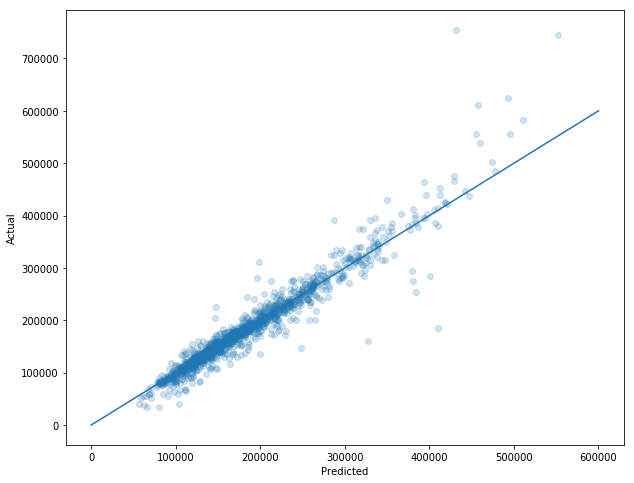

In [228]:
## Plotting the actual vs expected house price (along with the line x=y for reference)
plt.figure(figsize=(10,8))
plt.scatter(randomForest_best.predict(X_train), y_train, alpha=.2)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))
plt.xlabel("Predicted")
plt.ylabel("Actual");

## Transformed y

In [230]:
#randomForest_best = ensemble.RandomForestRegressor(n_estimators =25, min_samples_leaf=2, min_samples_split=6, random_state = 42)
cv_score = cross_val_score(randomForest_best, X_train, logy_train,  cv=5).mean()
cv_score

0.8540207095501182

In [231]:
cv_score = cross_val_score(randomForest_best, X_train, ybox_train,  cv=5).mean()
cv_score

0.8552453347975947

In [232]:
randomForest_best = ensemble.RandomForestRegressor(n_estimators =25, min_samples_leaf=2, min_samples_split=6, random_state = 42) 
randomForest_best.fit(X_train, ybox_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=6,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [233]:
ID = test_ID #Kaggle score 0.15668
result_rf_box = inv_boxcox(randomForest_best.predict(X_test), lambda_)  #lambda_ = -0.07692396374428875
output = pd.DataFrame( { 'id': ID , 'SalePrice': result_rf_box} )
output = output[['id', 'SalePrice']]

output.to_csv("solution.csv", index = False)
output.head(10)

,id,SalePrice
0,1461,124266.954859
1,1462,169004.983145
2,1463,179906.232821
3,1464,190516.567583
4,1465,194661.891182
5,1466,177619.043015
6,1467,168572.422255
7,1468,176280.698684
8,1469,189873.504961
9,1470,119426.788660
